In [1]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

# Import and Process Data

In [2]:
# import dataset (comes with colab!)
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')

# extract labels (number IDs) and remove from data
labels = data[:,0]
data   = data[:,1:]

# normalize the data to a range of [0 1]
dataNorm = (data - np.mean(data)) / (np.max(data) - np.mean(data))

In [3]:
# Step 1: convert to tensor
dataT   = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long()

# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)

# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

# Create the model

In [4]:
class FFNmodel(nn.Module):
  def __init__(self):
    super().__init__()

    # define the layers
    self.layer1 = nn.Linear(784,64)
    self.layer2 = nn.Linear(64,32)
    self.layer3 = nn.Linear(32,32)
    self.layer4 = nn.Linear(32,10)

  def forward(self,x):
    # define the forward function
    x = F.relu( self.layer1(x) )
    x = F.relu( self.layer2(x) )
    x = F.relu( self.layer3(x) )
    x = self.layer4(x)
    return x

In [5]:
def CreateFFNmodel():
  model = FFNmodel()

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.Adam(model.parameters(),lr=0.01)

  return model, lossfun, optimizer

# Explore the weights

In [6]:
tmpmodel = CreateFFNmodel()


print('Weights for Layer 1:')
print(tmpmodel[0].layer1.weight.data)
print('Shape of layer1 weight matrix:', tmpmodel[0].layer1.weight.data.shape)


Weights for Layer 1:
tensor([[ 0.0203, -0.0299, -0.0010,  ...,  0.0154,  0.0208,  0.0339],
        [ 0.0213, -0.0094, -0.0117,  ...,  0.0178,  0.0123,  0.0103],
        [ 0.0182,  0.0051, -0.0272,  ..., -0.0171, -0.0131, -0.0178],
        ...,
        [ 0.0096,  0.0318, -0.0327,  ...,  0.0008, -0.0158, -0.0083],
        [ 0.0339,  0.0279, -0.0031,  ..., -0.0327, -0.0031,  0.0186],
        [ 0.0044,  0.0090, -0.0053,  ..., -0.0067,  0.0291,  0.0048]])
Shape of layer1 weight matrix: torch.Size([64, 784])


# Function to train the model

In [7]:
def TrainFFNmodel(model, numepochs,lossfun, optimizer):

  # model, lossfun, optimizer = CreateFFNmodel()

   # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []


  # loop over epochs
  for epochi in range(numepochs):

    # switch on train mode
    model.train()

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = model(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    model.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = model(X)

    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )
  # end epochs

  # function output
  return trainAcc,testAcc,losses,model

# Run the model

In [8]:
model_base, lossfun, optimizer = CreateFFNmodel()
trainAcc_base,testAcc_base,losses_base,model_base = TrainFFNmodel(model_base, 10,lossfun, optimizer)

# Visualize the model

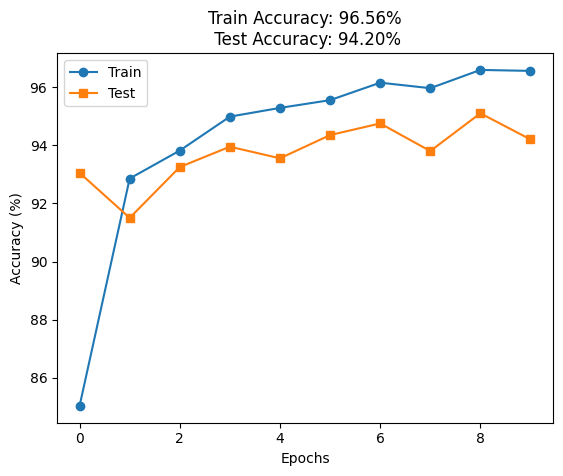

In [9]:
# plot the results
plt.plot(range(len(trainAcc_base)),trainAcc_base,'o-', range(len(testAcc_base)),testAcc_base ,'s-')
plt.legend(['Train','Test'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title(f'Train Accuracy: {trainAcc_base[-1]:.2f}%\n Test Accuracy: {testAcc_base[-1]:.2f}%')
plt.show()

# Set all the weights of layer2 to zero

In [14]:
# Change the weights before training
model_zero,lossfun,optimizer = CreateFFNmodel()

# set weighjts of layer1 of the model to zeros
model_zero.layer2.weight.data = torch.zeros( model_zero.layer1.weight.shape )

# confirm
torch.unique(model_zero.layer2.weight.data)

tensor([0.])

# Train the model again and visualize the results

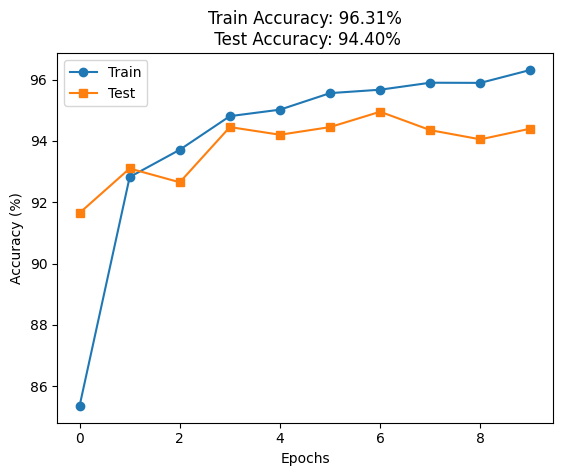

In [15]:
model_zero, lossfun, optimizer = CreateFFNmodel()
trainAcc_zero,testAcc_zero,losses_zero,model_zero = TrainFFNmodel(model_zero, 10,lossfun, optimizer)

# plot the results
plt.plot(range(len(trainAcc_zero)),trainAcc_zero,'o-', range(len(testAcc_zero)),testAcc_zero ,'s-')
plt.legend(['Train','Test'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title(f'Train Accuracy: {trainAcc_zero[-1]:.2f}%\n Test Accuracy: {testAcc_zero[-1]:.2f}%')
plt.show();

tensor([[ 0.0743,  0.1421,  0.0331,  ..., -0.0350,  0.1149, -0.3003],
        [ 0.1526, -0.0008,  0.7138,  ...,  0.0125,  0.0366,  0.0032],
        [ 0.0677,  0.0764, -0.2375,  ...,  0.0025, -0.0382,  0.0211],
        ...,
        [-0.0935,  0.1850, -0.2581,  ..., -0.0648, -0.0825,  0.2001],
        [ 0.0280, -0.1448, -0.0473,  ..., -0.0624, -0.1299, -0.0388],
        [ 0.1191,  0.0689,  0.5640,  ..., -0.0086,  0.1447,  0.0331]])


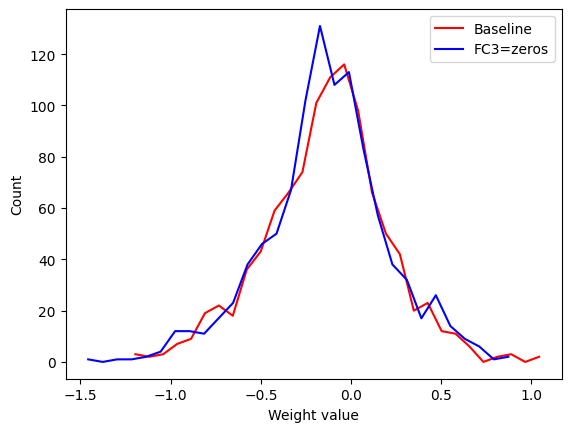

In [16]:
# Distribution of weights
print(model_zero.layer2.weight.data)

# show the distributions in a histogram
y,x = np.histogram(model_base.layer3.weight.data.flatten(),30)
plt.plot((x[1:]+x[:-1])/2,y,'r',label='Baseline')

y,x = np.histogram(model_zero.layer3.weight.data.flatten(),30)
plt.plot((x[1:]+x[:-1])/2,y,'b',label='FC3=zeros')

plt.legend()
plt.xlabel('Weight value')
plt.ylabel('Count')
plt.show();

# Change all learnable parameters to zero

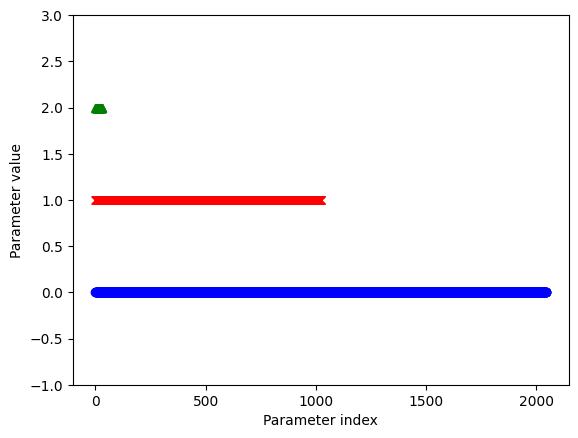

In [43]:
# Change the weights before training
model_allzero,lossfun,optimizer = CreateFFNmodel()

# loop over parameters and set them all to zeros
for p in model_allzero.named_parameters():
  p[1].data = torch.zeros_like( p[1].data )


# and confirm for a few select parameters (y-axis offset for visibility)
plt.plot(0+model_allzero.layer2.weight.data.flatten(),'bo')
plt.plot(1+model_allzero.layer3.weight.data.flatten(),'rx')
plt.plot(2+model_allzero.layer2.bias.data.flatten(),'g^')
plt.xlabel('Parameter index')
plt.ylim([-1,3])
plt.ylabel('Parameter value')
plt.show();

# Train the model with all parameters as zeros

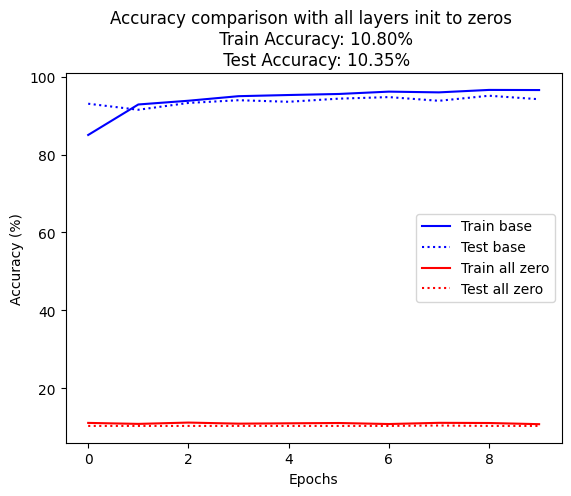

In [20]:
# run the model and show the results
trainAcc_allzero,testAcc_allzero,losses,model_allzero = TrainFFNmodel(model_allzero,10,lossfun,optimizer)

plt.plot(range(len(trainAcc_base)),trainAcc_base,'b-', range(len(testAcc_base)),testAcc_base ,'b:')
plt.plot(range(len(trainAcc_allzero)),trainAcc_allzero,'r-', range(len(testAcc_allzero)),testAcc_allzero ,'r:')
plt.legend(['Train base','Test base','Train all zero','Test all zero'])
plt.title(f'Accuracy comparison with all layers init to zeros \n Train Accuracy: {trainAcc_allzero[-1]:.2f}%\n Test Accuracy: {testAcc_allzero[-1]:.2f}%')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.show();

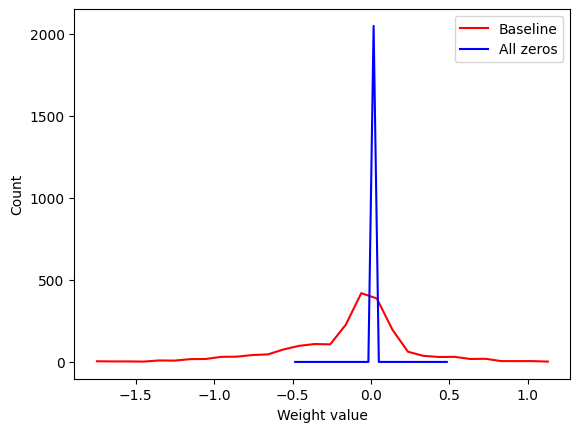

In [21]:
# show the distributions in a histogram
y,x = np.histogram(model_base.layer2.weight.data.flatten(),30)
plt.plot((x[1:]+x[:-1])/2,y,'r',label='Baseline')

y,x = np.histogram(model_allzero.layer2.weight.data.flatten(),30)
plt.plot((x[1:]+x[:-1])/2,y,'b',label='All zeros')

plt.legend()
plt.xlabel('Weight value')
plt.ylabel('Count')
plt.show();

In [69]:
import time

# Initialize the weights to Gaussian random numbers with standard deviations between .0001 and 10 in 25 logarithmic steps
stdevs = torch.logspace(-4, 1, 25)

# set the bin size for histograms
histbins = 80

# initialize the results output matrix
accresults = np.zeros(len(stdevs))
histdata = np.zeros(((len(stdevs),2,histbins)))

# Start timer
startTime = time.process_time()

# loop over the different standard deviations
for i in range(len(stdevs)):
  model_gaussian,lossfun,optimizer = CreateFFNmodel()

  # Loop over all model parameters
  for p in model_gaussian.named_parameters():
    p[1].data = torch.randn_like( p[1].data ) * stdevs[i]

  # Train the model
  trainAcc_gaussian,testAcc_gaussian,_,model_gaussian = TrainFFNmodel(model_gaussian,10,lossfun,optimizer)

  # Get the accuracy results for last 3 epochs
  accresults[i] = np.mean(testAcc_gaussian[-3:])

  tmpparmas = np.array([])
  # Collect all parameters into a vecotr to calulcate the histogram
  for p in model_gaussian.named_parameters():
    tmpparmas = np.append( tmpparmas, p[1].data.numpy().flatten() )

  # Compute the histograms
  y,x = np.histogram(tmpparmas,histbins)
  histdata[i,0,:] = (x[1:] + x[:-1])/2
  histdata[i,1,:] = y

  # Verbosity
  timeElapsed = time.process_time() - startTime
  print(f'Completed {i+1}/{len(stdevs)} with accuracy {accresults[i]:.2f}; time taken: {timeElapsed:3.0f} seconds')


Completed 1/25 with accuracy 10.38; time taken:  16 seconds
Completed 2/25 with accuracy 93.88; time taken:  29 seconds
Completed 3/25 with accuracy 93.70; time taken:  43 seconds
Completed 4/25 with accuracy 94.20; time taken:  56 seconds
Completed 5/25 with accuracy 94.62; time taken:  70 seconds
Completed 6/25 with accuracy 94.27; time taken:  83 seconds
Completed 7/25 with accuracy 94.03; time taken:  96 seconds
Completed 8/25 with accuracy 94.62; time taken: 111 seconds
Completed 9/25 with accuracy 93.75; time taken: 125 seconds
Completed 10/25 with accuracy 93.75; time taken: 138 seconds
Completed 11/25 with accuracy 94.40; time taken: 152 seconds
Completed 12/25 with accuracy 94.65; time taken: 165 seconds
Completed 13/25 with accuracy 94.55; time taken: 179 seconds
Completed 14/25 with accuracy 95.30; time taken: 191 seconds
Completed 15/25 with accuracy 94.47; time taken: 203 seconds
Completed 16/25 with accuracy 94.62; time taken: 216 seconds
Completed 17/25 with accuracy 94.

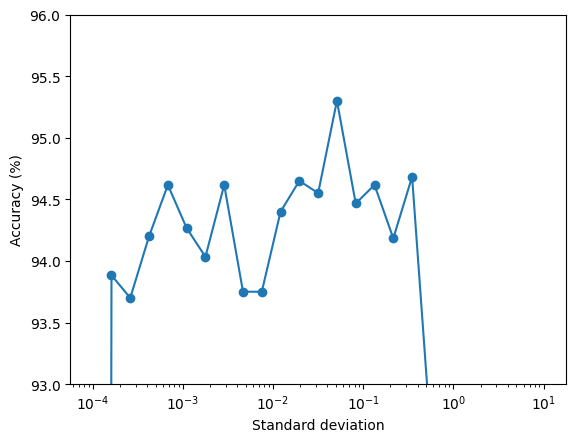

In [82]:
# Plot the accuracies against stdevs

plt.plot(stdevs,accresults,'o-')
plt.xlabel('Standard deviation')
plt.ylabel('Accuracy (%)')
plt.xscale('log')
plt.ylim([93,96])
plt.show();


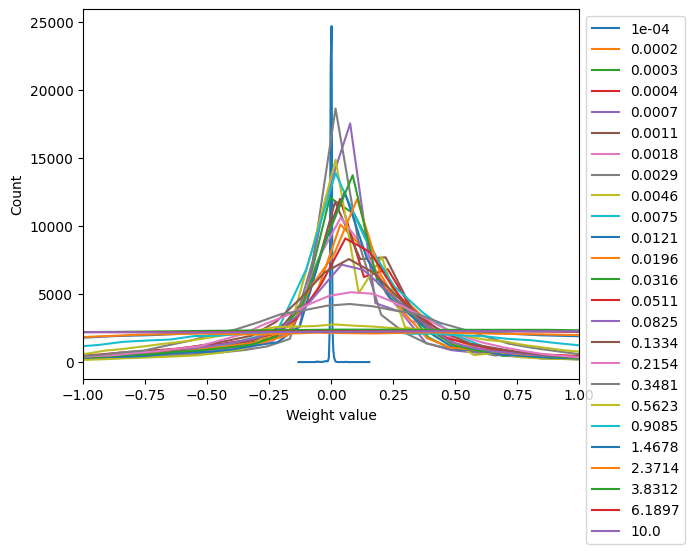

In [113]:
# Plot the weight distributions against stdevs

for i in range(len(stdevs)):
  plt.plot(histdata[i,0,:],histdata[i,1,:])

plt.xlabel('Weight value')
plt.ylabel('Count')
plt.xlim([-1,1])
plt.legend(np.round(stdevs,4).numpy(),bbox_to_anchor=(1, 1),loc='upper left')
plt.show();
#